# Importações

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from sklearn.impute import KNNImputer
import datetime

# Criando variáveis organizacionais

In [2]:
path = '../raw_data/SP' #caminho geral
files = [f for f in listdir(path) if isfile(join(path, f))] #lista de nomes de arquivos de dados

# Tratamentos iniciais dos dados

## Tratamentos básicos

In [3]:
#---------------------fazer list com os dataframes---------------------
df_list = []
for file in range(0,88): # máximo 88
    df = pd.read_csv(f'../raw_data/SP/{files[file]}', sep=';', skiprows=8, encoding="ISO-8859-1", decimal=',')
    lat_log_alt = pd.read_csv(f'../raw_data/SP/{files[file]}', sep=';', skiprows=4,
                          nrows=3, encoding="ISO-8859-1", decimal=',', names=['lat_lon_alt','valor'])
    df['Estaçao']=files[file].split('_')[4]
    df['Latitude']=lat_log_alt['valor'][0]
    df['Longitude']=lat_log_alt['valor'][1]
    df['Altitude']=lat_log_alt['valor'][2]
    df_list.append(df)
df_list

#---------------------fundir os dataframes no dataframe vazio---------------------
full_df = pd.concat(df_list)
full_df
df2 = full_df.copy()

#---------------------dropar coluna inútil---------------------
df2.drop(columns=["Unnamed: 19"],inplace=True)

#---------------------mudar nome das colunas---------------------
df2= df2.rename(columns={'Data': 'Data',
                                            'Hora UTC': 'Hora(UTC)',
                                            'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'Chuva',
                                            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'Pres',
                                            'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'Pres.max',
                                            'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'Pres.min',
                                            'RADIACAO GLOBAL (Kj/m²)': 'Radiacao',
                                            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'Temp',
                                            'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'Temp.orvalho',
                                            'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'Temp.max',
                                            'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'Temp.min',
                                            'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'Temp.orvalho.max',
                                            'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'Temp.orvalho.min',
                                            'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'Umid.max',
                                            'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'Umid.min',
                                            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'Umid',
                                            'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'Dir.vento',
                                            'VENTO, RAJADA MAXIMA (m/s)': 'Rajada.vento',
                                            'VENTO, VELOCIDADE HORARIA (m/s)': 'Vel.vento'})

## Transformação de dados e preenchimento

### Formatando data e hora

In [4]:
%%time
#---------------------colocando data e hora no formato adequado---------------------
#df2["Data"] = pd.to_datetime(df2["Data"])
df2['datahora'] = df2.apply(lambda row: pd.to_datetime(f'{row["Data"]} {row["Hora(UTC)"]}'), axis=1)

CPU times: user 2min 33s, sys: 991 ms, total: 2min 34s
Wall time: 2min 34s


### Transformando chuva em variável categórica

Chuva fraca Precipitação cuja intensidade é menor do que 5,0 mm/h.
Chuva
moderada
Precipitação cuja intensidade está compreendida entre 5,0
e 25 mm/h.
Chuva forte Precipitação cuja intensidade está compreendida entre
25,1 e 50 mm/h.
Chuva muito
forte Precipitação cuja intensidade é maior do que 50,0 mm/h.


In [6]:
# KNNInputer antes de passar pela classificação
# Manter os NAN, estão sendo computados como chuva muito forte
# Retirar arquivos sem dados:
# AVARE                        
# BARRA BONITA                 
# BARRA DO TURVO               
# CRIOSFERA 
# Analisar outros com pouquissimo acumulo de chuva

In [46]:
%%time
#---------------------transformando a chuva em variável categórica---------------------
def classe_chuva(precipitacao):
    mm=precipitacao
    if np.isnan(mm):
        chuva = "NaN"
    if mm == 0:
        chuva = 'nao chove'
    elif mm >0 and mm <=5.0:
        chuva = 'fraca'
    elif mm >5.0 and mm<=25.0:
        chuva = 'moderada'
    elif mm >25.0 and mm<=50:
        chuva = 'forte'
    else:
        chuva = 'muito forte'
    return chuva

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


### Tratando valores nulos de radiação

In [8]:
%%time
#---------------------Tratando valores nulos de radiação---------------------
def tratar_radiacao(hora,radiacao):
    if (hora.hour >= 22) or (hora.hour <= 8):
        if np.isnan(radiacao):
            radiacao = 0
    return radiacao
df2['Radiacao'] = df2.apply(lambda x: tratar_radiacao(x['datahora'],x['Radiacao']),axis=1)

CPU times: user 11.9 s, sys: 344 ms, total: 12.3 s
Wall time: 12.3 s


In [9]:
df2[df2['Estaçao']=='OURINHOS']

,Data,Hora(UTC),Chuva,Pres,Pres.max,Pres.min,Radiacao,Temp,Temp.orvalho,Temp.max,...,Umid,Dir.vento,Rajada.vento,Vel.vento,Estaçao,Latitude,Longitude,Altitude,datahora,classe_chuva
0,2021/01/01,0000 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.948889,-49.894444,443.49,2021-01-01 00:00:00+00:00,muito forte
1,2021/01/01,0100 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.948889,-49.894444,443.49,2021-01-01 01:00:00+00:00,muito forte
2,2021/01/01,0200 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.948889,-49.894444,443.49,2021-01-01 02:00:00+00:00,muito forte
3,2021/01/01,0300 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.948889,-49.894444,443.49,2021-01-01 03:00:00+00:00,muito forte
4,2021/01/01,0400 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.948889,-49.894444,443.49,2021-01-01 04:00:00+00:00,muito forte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020/12/31,1900 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.949000,-49.894546,443.49,2020-12-31 19:00:00+00:00,muito forte
8780,2020/12/31,2000 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.949000,-49.894546,443.49,2020-12-31 20:00:00+00:00,muito forte
8781,2020/12/31,2100 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.949000,-49.894546,443.49,2020-12-31 21:00:00+00:00,muito forte
8782,2020/12/31,2200 UTC,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,OURINHOS,-22.949000,-49.894546,443.49,2020-12-31 22:00:00+00:00,muito forte


### Imputer da variável de vento

In [ ]:
# %%time
# #---------------------fazer imputer nas colunas de vento---------------------
# imputer = KNNImputer(n_neighbors=2)
# imputer.fit_transform(df2[['Rajada.vento', 'Vel.vento', 'Dir.vento']])

# Explorando os dados

In [10]:
#verificando células nulas
df2.isnull().sum().sort_values(ascending=False)/len(df2)

Chuva               0.430383
Rajada.vento        0.365002
Dir.vento           0.363401
Vel.vento           0.363394
Temp.orvalho.min    0.341681
Temp.orvalho.max    0.341461
Umid.max            0.340781
Umid.min            0.340741
Temp.orvalho        0.337966
Umid                0.337858
Temp.max            0.326703
Temp.min            0.326701
Pres.min            0.326053
Pres.max            0.326040
Temp                0.324374
Pres                0.323719
Radiacao            0.199400
datahora            0.000000
Longitude           0.000000
Altitude            0.000000
Data                0.000000
Latitude            0.000000
Estaçao             0.000000
Hora(UTC)           0.000000
classe_chuva        0.000000
dtype: float64

## Acumulado de chuva por estação

In [45]:
#-----------------------plotando a distribuição das variáveis---------------

df2['Chuva'].groupby(df2['Estaçao']).sum()

Estaçao
ARIRANHA                    30.0
AVARE                        0.0
BARRA BONITA                 0.0
BARRA DO TURVO               0.0
BARRETOS                  1803.2
BARUERI                    989.4
BAURU                     2140.0
BEBDOURO                   791.0
BEBEDOURO                  552.2
BERTIOGA                   124.8
BRAGANCA PAULISTA         2352.6
CACHOEIRA PAULISTA         857.0
CAMPOS DO JORDAO          1535.6
CASA BRANCA                717.8
CRIOSFERA                    0.0
DRACENA                   1457.4
FRANCA                    1282.0
IBITINGA                    21.8
IGUAPE                    3928.2
ITAPEVA                   1734.4
ITAPIRA                    852.4
ITATIAIA                  4422.0
ITUVERAVA                 1037.8
JALES                      920.6
JOSE BONIFACIO             710.8
LINS                       800.6
MARILIA                   2534.2
OURINHOS                   654.0
PARATI                    2401.6
PIRACICABA                 624.8
PR

In [44]:
df2[df2['Estaçao']=='REGISTRO'].isnull().sum()/df2[df2.Estaçao=='REGISTRO'].shape[0]

Data                0.000000
Hora(UTC)           0.000000
Chuva               0.883208
Pres                0.819596
Pres.max            0.820907
Pres.min            0.820907
Radiacao            0.361263
Temp                0.819596
Temp.orvalho        0.820223
Temp.max            0.820907
Temp.min            0.820907
Temp.orvalho.max    0.821363
Temp.orvalho.min    0.821363
Umid.max            0.821363
Umid.min            0.821363
Umid                0.820223
Dir.vento           0.825125
Rajada.vento        0.828887
Vel.vento           0.825125
Estaçao             0.000000
Latitude            0.000000
Longitude           0.000000
Altitude            0.000000
datahora            0.000000
classe_chuva        0.000000
dtype: float64

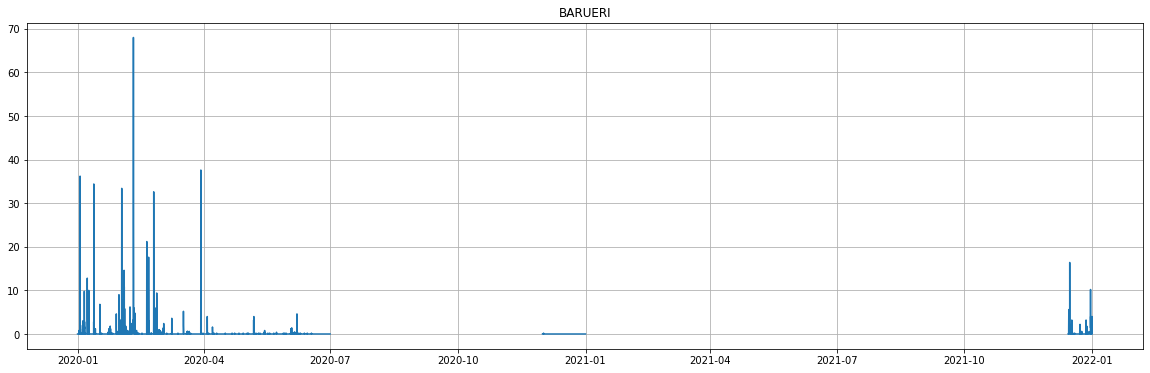

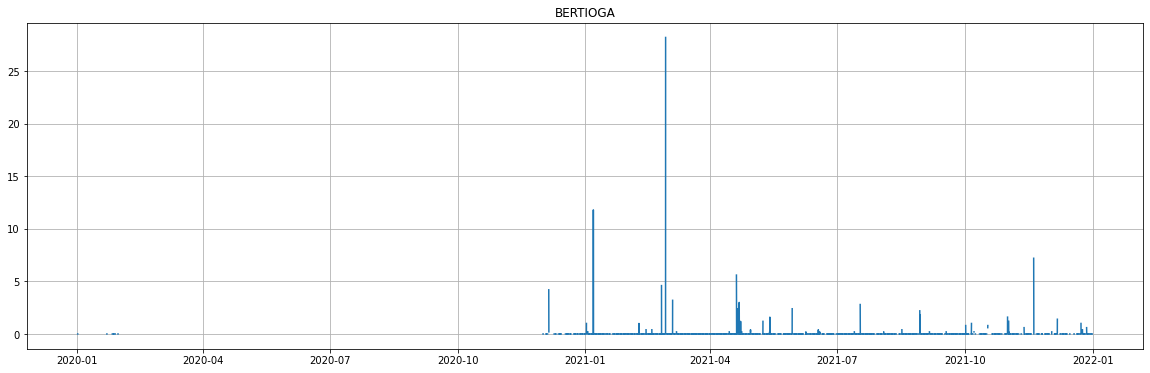

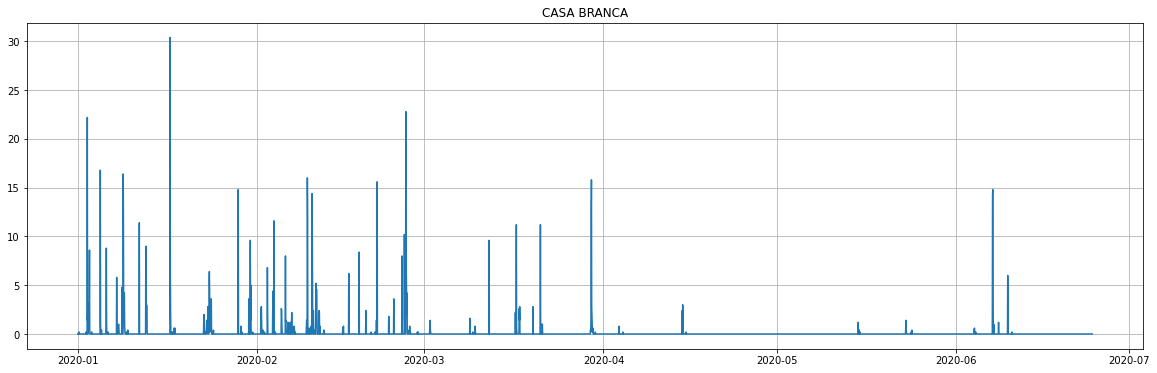

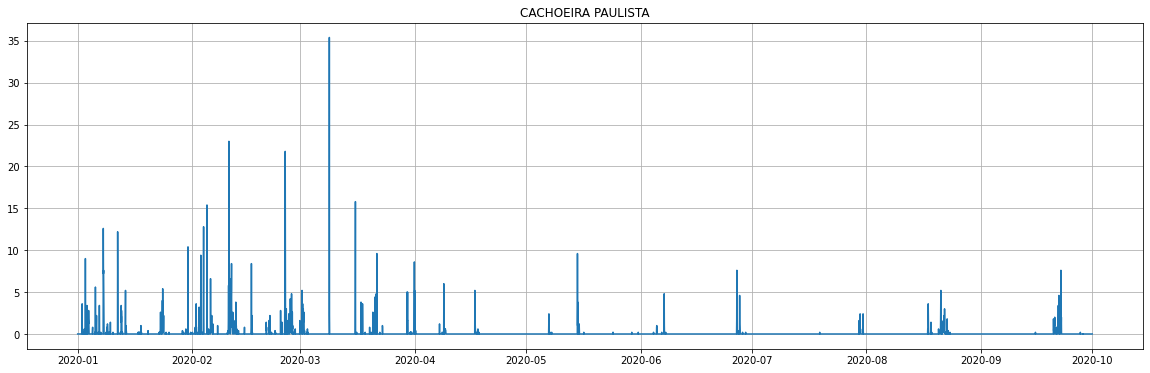

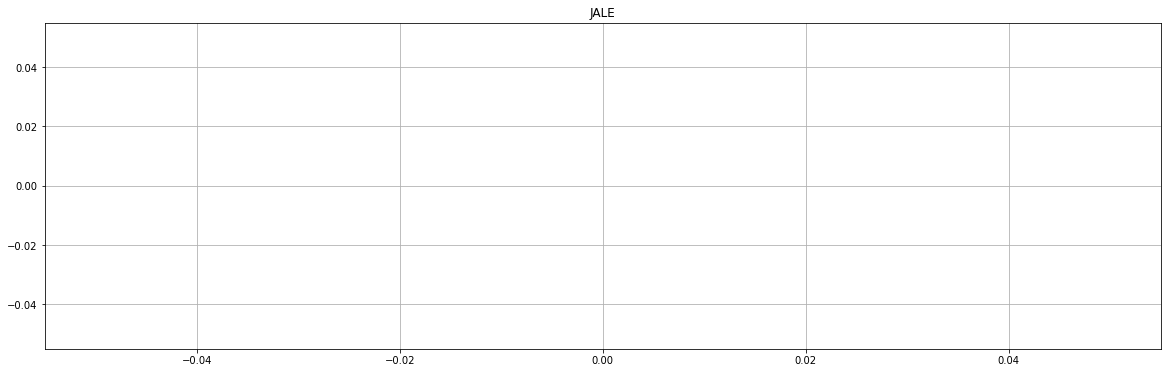

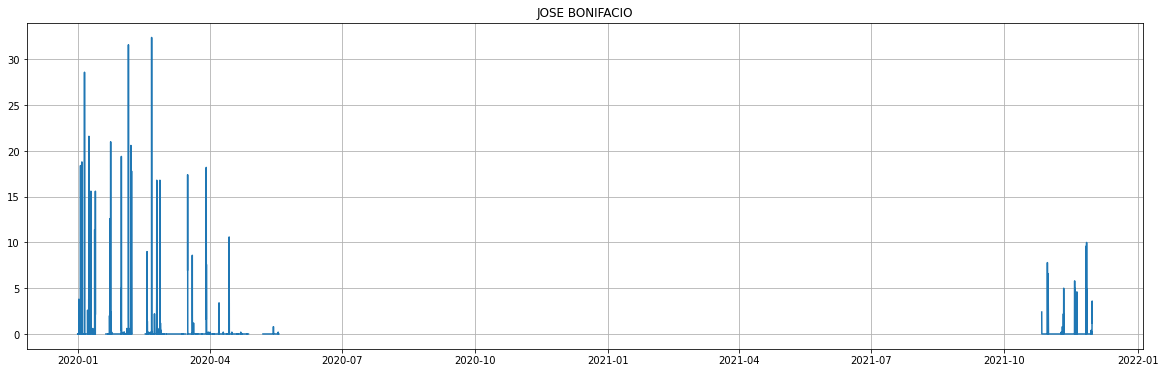

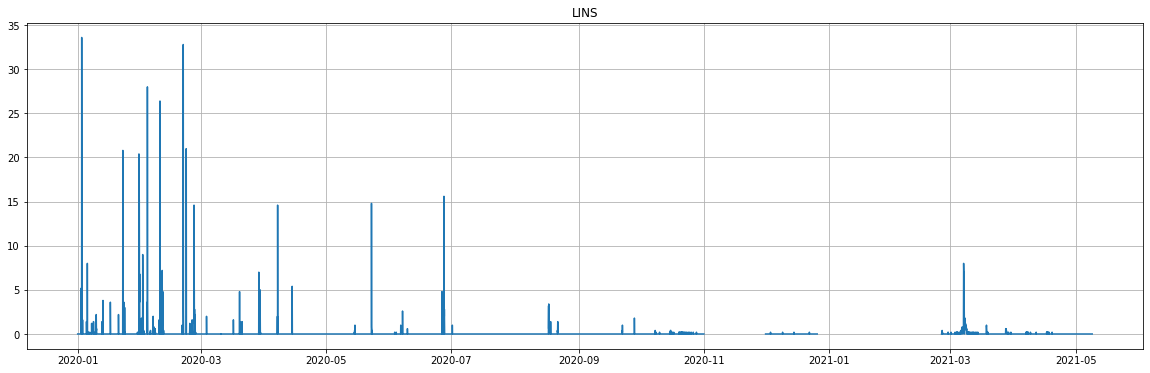

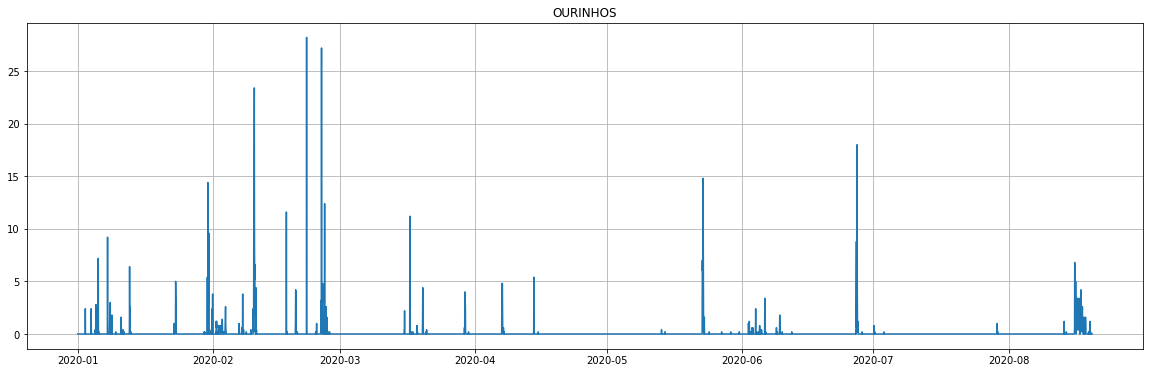

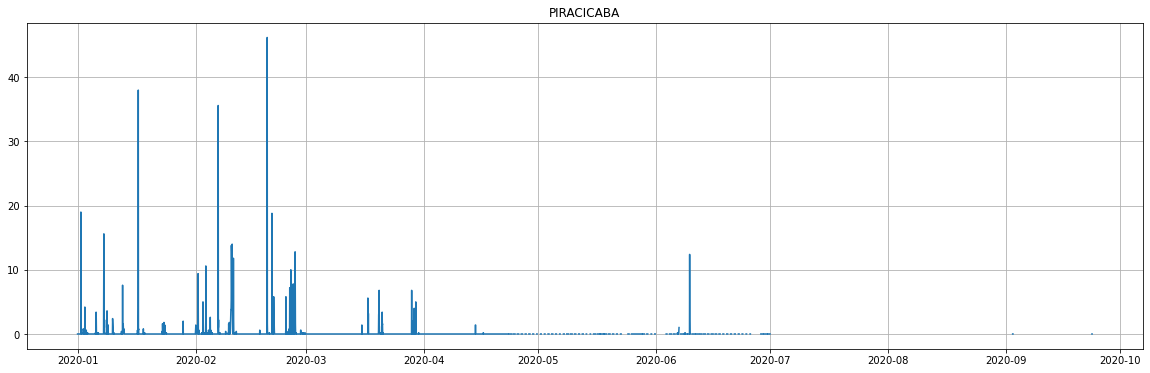

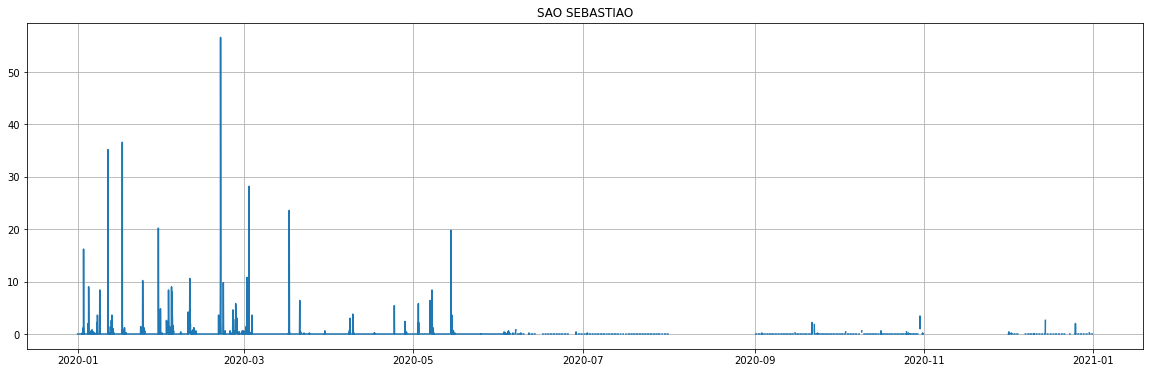

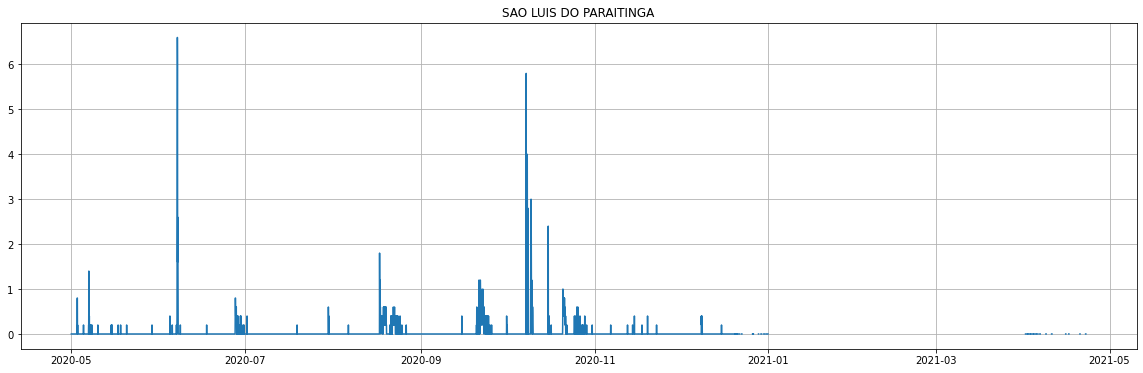

In [40]:
import matplotlib.pyplot as plt

list=['BARUERI', 'BERTIOGA', 'CASA BRANCA', 'CACHOEIRA PAULISTA', 'JALE', 'JOSE BONIFACIO', 'LINS', 
      'OURINHOS', 'PIRACICABA', 'SAO SEBASTIAO', 'SAO LUIS DO PARAITINGA' ]
for city in list:
    dado=df2[df2.Estaçao==city]
    
    fig = plt.figure(figsize=(20,6))
    plt.plot(dado.datahora, dado.Chuva, '-')
    plt.title(city)
    plt.grid()
    plt.show();
    